# Meta learning momentum parameter
Can we learn/meta-learn the momentum parameter using the gradient of the loss during training?


I found out the gradient of the momentum parameter is VERY noisy and randomly jumps down two orders of magnitude in the prime of training.
I normalized the gradient to ignore magnitude (normalize to one) and ran the optimization.
The graph of momentum increases then decreases later, but it seems like high momentum ALWAYS is a better strategy for the long term.
In short, optimizing momentum decreases it (optimal for the short term) instead of keeping it high (optimal for the long term).


Later on, can we learn/meta-learn all the hardcoded parameters? maybe even look ahead of the optimization using meta-learning of the past history of weights?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
import util

In [4]:
ds = cifar10.CIFAR10()
# ds = mnist.MNIST()
model = cifar10.BigNetwork

Files already downloaded and verified
Files already downloaded and verified


In [5]:
net = model()

In [201]:
def train_adam(net, accu, n_epochs=5, lr=1e-2):
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    for epoch_idx in range(n_epochs):
        for x, y in tqdm(ds.dl_train):
            x, y = x.to(device), y.to(device)
            yp = net(x)
            loss = ds.loss_fn(yp, y)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            print(loss.item())
            accu.append(loss_batch=loss.item())
        data_test = ds.calc_performance(net, dl=ds.dl_test, tqdm=tqdm, device=device)
        accu.append(loss_test=data_test['loss'], acc_test=data_test['acc'])
            
def train_sgd(net, accu, n_epochs=5, lr=1e-2, momentum=0):
    net = net.to(device)
    m = None
    for epoch_idx in range(n_epochs):
        for x, y in tqdm(ds.dl_train):
            x, y = x.to(device), y.to(device)
            yp = net(x)
            loss = ds.loss_fn(yp, y)
            
            for pi in net.parameters():
                pi.grad = None
                
            loss.backward()
            
            if m is None:
                m = [pi.grad.detach() for pi in net.parameters()]
            else:
                m = [momentum*mi+pi.grad.detach() for mi, pi in zip(m, net.parameters())]
                
            for pi, mi in zip(net.parameters(), m):
                pi.data -= lr*mi
            
            # print(loss.item())
            accu.append(loss_batch=loss.item(), momentum=momentum)
        data_test = ds.calc_performance(net, dl=ds.dl_test, tqdm=tqdm, device=device)
        accu.append(loss_test=data_test['loss'], acc_test=data_test['acc'])
            
def train_meta(net, accu, n_epochs=5, lr=1e-2, momentum=0, lr_momentum=1e-2):
    net = net.to(device)
    momentum = np.log(momentum/(1-momentum))
    momentum = torch.tensor(momentum).float().to(device).requires_grad_()
    
    # opt = torch.optim.SGD([momentum], lr=lr_momentum, momentum=.9)
    opt = torch.optim.Adam([momentum], lr=lr_momentum)
    
    vp = torch.cat([pi.flatten().detach() for pi in net.parameters()]).detach()
    m = torch.zeros_like(vp)
    g = torch.zeros_like(vp)
    
    mgs = []
    for epoch_idx in tqdm(range(n_epochs)):
        pbar = tqdm(ds.dl_train, leave=False)
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            m = momentum.sigmoid()*m.detach() + g
                
            v = vp.detach() - lr*m
            
            nn.utils.vector_to_parameters(v, net.parameters())
            yp = net(x)
            loss = ds.loss_fn(yp, y)
            
            for pi in net.parameters():
                pi.grad = None
            # momentum.grad = None
            opt.zero_grad()
                
            loss.backward()
            g = torch.cat([pi.grad.flatten().detach() for pi in net.parameters()]).detach()
            
            if v.grad_fn is not None:
                v.backward(g)
                # mg = momentum.grad
                # print(mg.item())
                # momentum = (momentum.detach() - lr_momentum*mg).requires_grad_()
                # mgs.append(momentum.grad.item())
                # mgsarr = np.array(mgs)
                # if np.abs(momentum.grad.item()-mgsarr.mean())>3*
                if momentum.grad.abs()>1e-10:
                    momentum.grad = momentum.grad/momentum.grad.abs()
                opt.step()
            
            vp = v
                
            # momentum -= lr_momentum*(-lr*np.sum([torch.sum(mi) for mi in m]))
            
            # print(loss.item(), momentum.sigmoid().item())
            pbar.set_postfix_str(f'loss={loss.item()}, m={momentum.sigmoid().item()}, mg={momentum.grad.item()}')
            accu.append(loss_batch=loss.item(), momentum=momentum.sigmoid().item(), mg=momentum.grad.item())
        data_test = ds.calc_performance(net, dl=ds.dl_test, tqdm=tqdm, device=device)
        accu.append(loss_test=data_test['loss'], acc_test=data_test['acc'])
            
            


In [206]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')

In [207]:
data = {}

In [212]:
# for momentum in [.9, .95, .999]:
for momentum in [.99]:
    for t in ['meta', 'sgdm']:
        accu = util.Accumulator()
        torch.manual_seed(0)
        net = model().to(device)
        train_meta(net, accu, n_epochs=25, lr=1e-2, momentum=momentum, lr_momentum=1e-2 if t=='meta' else 0)
        data[f'{t}_m0={momentum}'] = accu


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

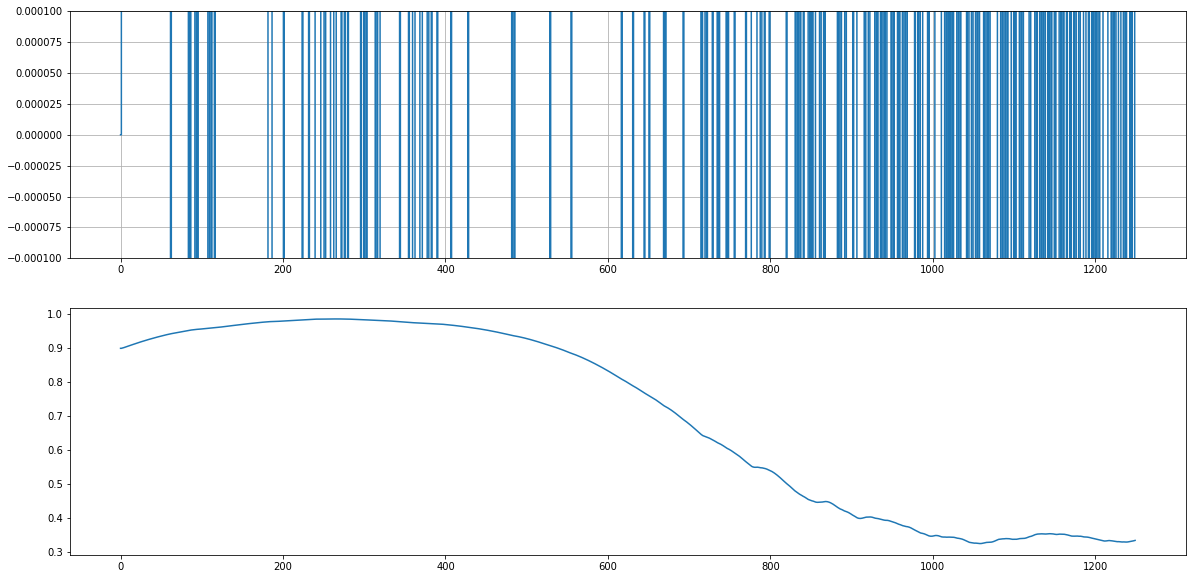

In [213]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(-data['meta_m0=0.9']['mg'])
plt.ylim(-1e-4, 1e-4)
plt.grid()
plt.subplot(212)
plt.plot(data['meta_m0=0.9']['momentum'])

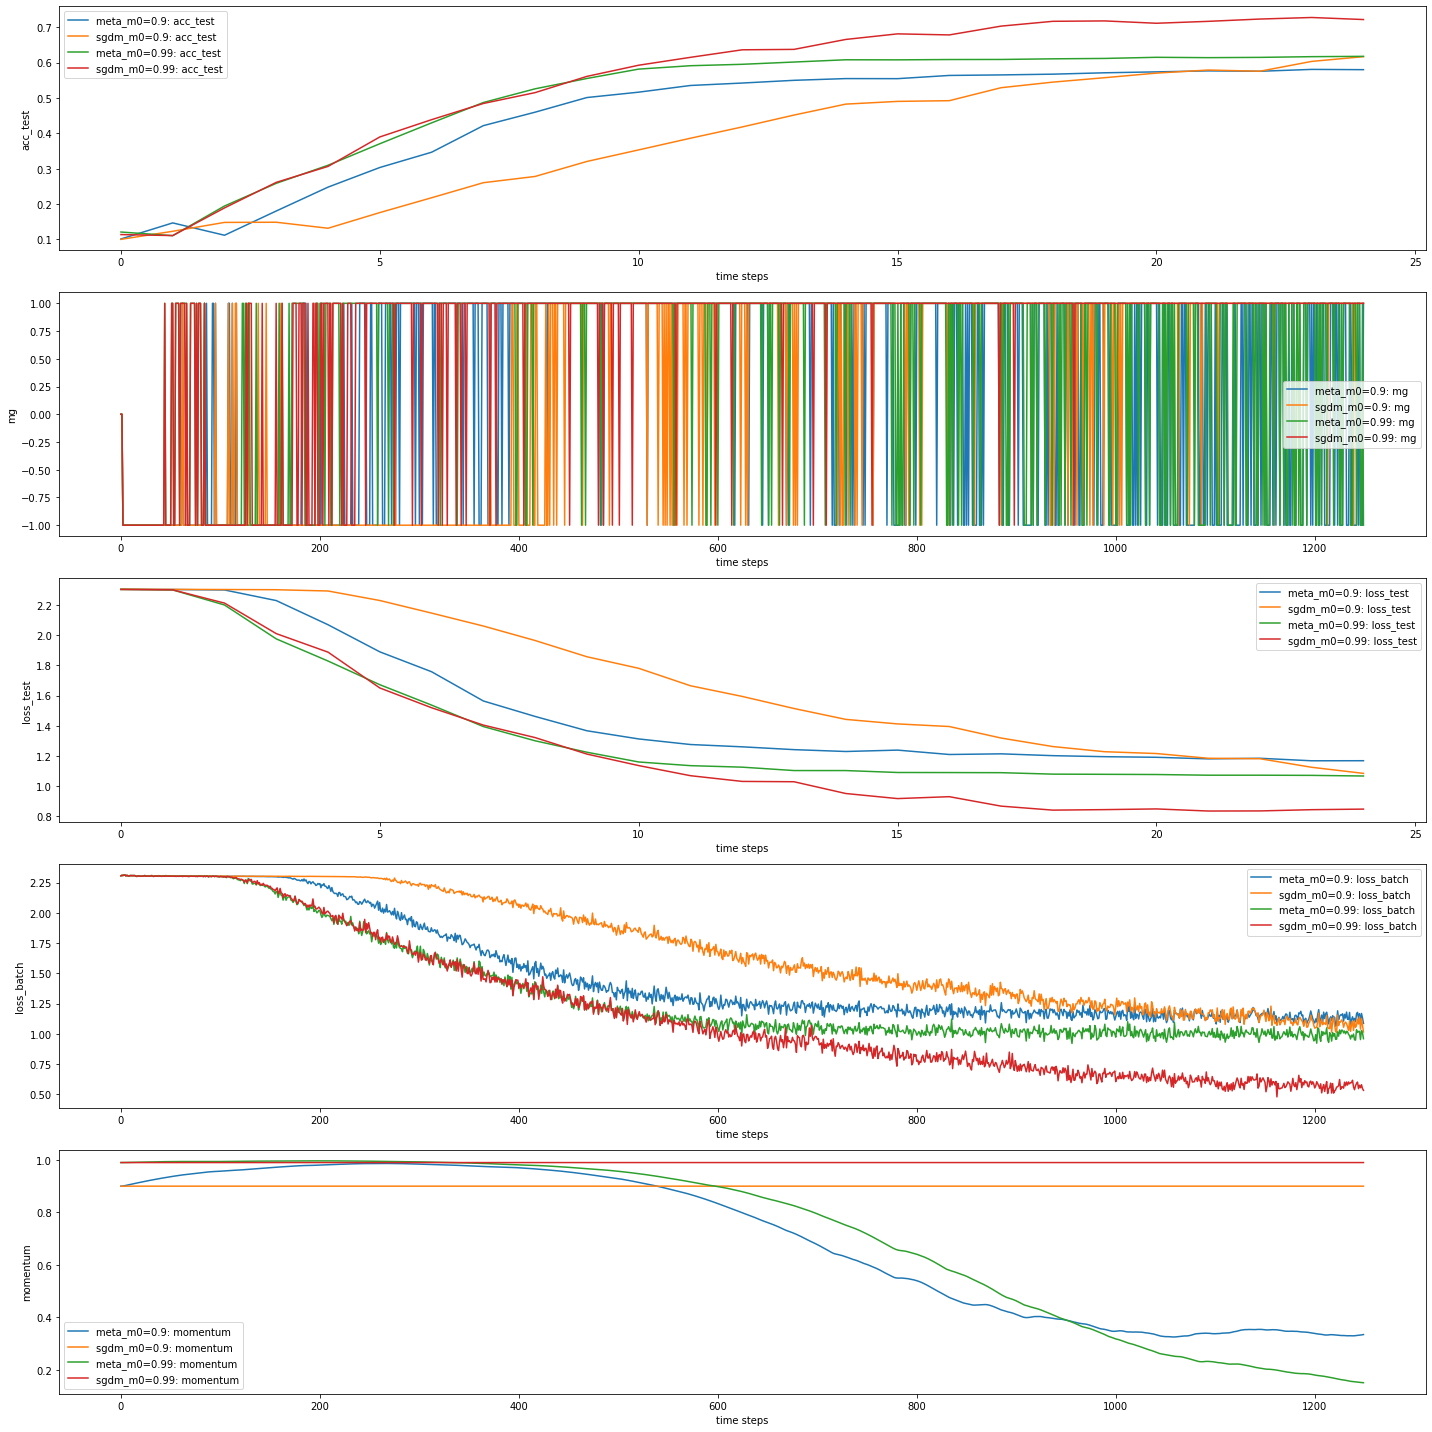

In [214]:
fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('white')
util.plot_accumulators(data)

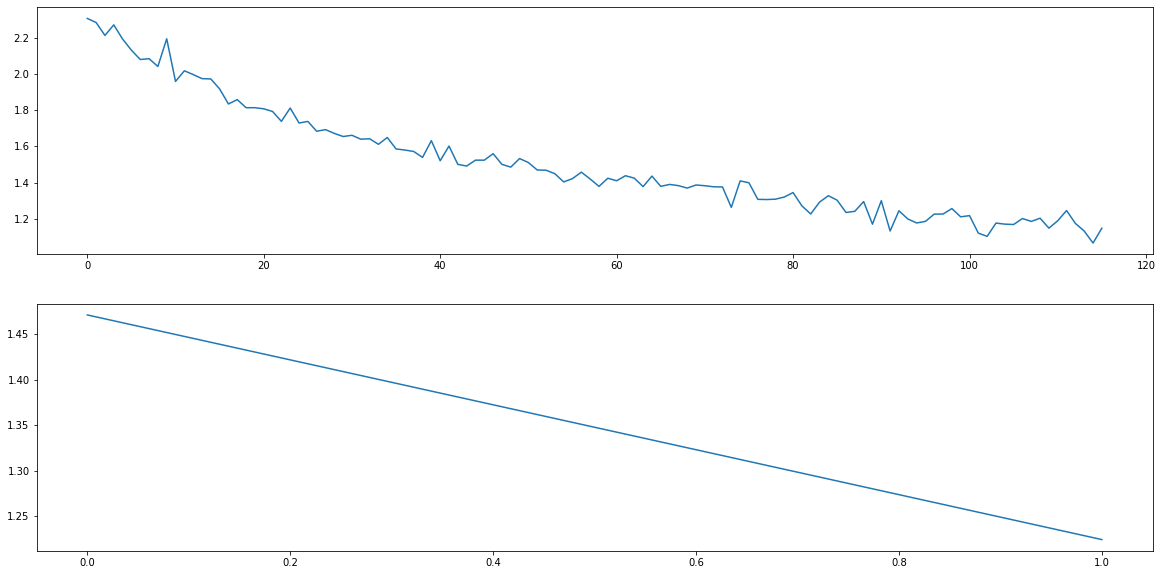

In [46]:
plt.figure(figsize=(20, 10))
plt.subplot(211)
plt.plot(accu['loss_batch'])
plt.subplot(212)
plt.plot(accu['loss_test'])

In [153]:
# data = {'sgdm': util.Accumulator(), 'meta': util.Accumulator()}
# torch.manual_seed(0)
# train_sgd(model(), data['sgdm'], lr=1e-2, momentum=0.01)
data['meta'] = util.Accumulator()
torch.manual_seed(0)
train_meta(model(), data['meta'], lr=1e-2, momentum=-1, lr_momentum=1e-2)

  0%|          | 0/50 [00:00<?, ?it/s]

2.3067383766174316 tensor(0.2689, grad_fn=<SigmoidBackward0>)
2.3106906414031982 tensor(0.2689, grad_fn=<SigmoidBackward0>)
2.3092284202575684 tensor(0.2702, grad_fn=<SigmoidBackward0>)
2.3072946071624756 tensor(0.2717, grad_fn=<SigmoidBackward0>)
2.311000108718872 tensor(0.2734, grad_fn=<SigmoidBackward0>)
2.3116979598999023 tensor(0.2751, grad_fn=<SigmoidBackward0>)
2.3115134239196777 tensor(0.2770, grad_fn=<SigmoidBackward0>)
2.303755521774292 tensor(0.2788, grad_fn=<SigmoidBackward0>)
2.309750556945801 tensor(0.2807, grad_fn=<SigmoidBackward0>)
2.3104660511016846 tensor(0.2826, grad_fn=<SigmoidBackward0>)
2.309832811355591 tensor(0.2845, grad_fn=<SigmoidBackward0>)
2.3092429637908936 tensor(0.2865, grad_fn=<SigmoidBackward0>)
2.3064935207366943 tensor(0.2885, grad_fn=<SigmoidBackward0>)
2.3098902702331543 tensor(0.2905, grad_fn=<SigmoidBackward0>)
2.3047616481781006 tensor(0.2925, grad_fn=<SigmoidBackward0>)
2.3134427070617676 tensor(0.2946, grad_fn=<SigmoidBackward0>)
2.3135778903

  0%|          | 0/50 [00:00<?, ?it/s]

2.309032678604126 tensor(0.3735, grad_fn=<SigmoidBackward0>)
2.3072969913482666 tensor(0.3758, grad_fn=<SigmoidBackward0>)
2.314378261566162 tensor(0.3784, grad_fn=<SigmoidBackward0>)
2.3112642765045166 tensor(0.3810, grad_fn=<SigmoidBackward0>)
2.30700421333313 tensor(0.3836, grad_fn=<SigmoidBackward0>)
2.3021843433380127 tensor(0.3862, grad_fn=<SigmoidBackward0>)
2.309767961502075 tensor(0.3888, grad_fn=<SigmoidBackward0>)
2.3096604347229004 tensor(0.3915, grad_fn=<SigmoidBackward0>)
2.3075430393218994 tensor(0.3940, grad_fn=<SigmoidBackward0>)
2.309297561645508 tensor(0.3967, grad_fn=<SigmoidBackward0>)
2.3103225231170654 tensor(0.3994, grad_fn=<SigmoidBackward0>)
2.3089494705200195 tensor(0.4022, grad_fn=<SigmoidBackward0>)
2.308406114578247 tensor(0.4050, grad_fn=<SigmoidBackward0>)
2.311743974685669 tensor(0.4078, grad_fn=<SigmoidBackward0>)
2.3070731163024902 tensor(0.4107, grad_fn=<SigmoidBackward0>)
2.303440809249878 tensor(0.4134, grad_fn=<SigmoidBackward0>)
2.299071550369262

  0%|          | 0/50 [00:00<?, ?it/s]

2.3077902793884277 tensor(0.5014, grad_fn=<SigmoidBackward0>)
2.2980778217315674 tensor(0.5036, grad_fn=<SigmoidBackward0>)
2.310997486114502 tensor(0.5059, grad_fn=<SigmoidBackward0>)
2.3032772541046143 tensor(0.5081, grad_fn=<SigmoidBackward0>)
2.3096282482147217 tensor(0.5104, grad_fn=<SigmoidBackward0>)
2.303598165512085 tensor(0.5127, grad_fn=<SigmoidBackward0>)
2.3052003383636475 tensor(0.5150, grad_fn=<SigmoidBackward0>)
2.3080503940582275 tensor(0.5174, grad_fn=<SigmoidBackward0>)
2.301922559738159 tensor(0.5198, grad_fn=<SigmoidBackward0>)
2.3053605556488037 tensor(0.5221, grad_fn=<SigmoidBackward0>)
2.304962396621704 tensor(0.5245, grad_fn=<SigmoidBackward0>)
2.3044686317443848 tensor(0.5268, grad_fn=<SigmoidBackward0>)
2.3042080402374268 tensor(0.5290, grad_fn=<SigmoidBackward0>)
2.3041067123413086 tensor(0.5312, grad_fn=<SigmoidBackward0>)
2.3072192668914795 tensor(0.5334, grad_fn=<SigmoidBackward0>)
2.3045220375061035 tensor(0.5355, grad_fn=<SigmoidBackward0>)
2.3024837970

  0%|          | 0/50 [00:00<?, ?it/s]

2.306022882461548 tensor(0.6211, grad_fn=<SigmoidBackward0>)
2.3020098209381104 tensor(0.6234, grad_fn=<SigmoidBackward0>)
2.305481195449829 tensor(0.6258, grad_fn=<SigmoidBackward0>)
2.305784225463867 tensor(0.6281, grad_fn=<SigmoidBackward0>)
2.3091681003570557 tensor(0.6305, grad_fn=<SigmoidBackward0>)
2.3043668270111084 tensor(0.6329, grad_fn=<SigmoidBackward0>)
2.3040778636932373 tensor(0.6353, grad_fn=<SigmoidBackward0>)
2.304307460784912 tensor(0.6377, grad_fn=<SigmoidBackward0>)
2.3079869747161865 tensor(0.6401, grad_fn=<SigmoidBackward0>)
2.306410551071167 tensor(0.6425, grad_fn=<SigmoidBackward0>)
2.30993390083313 tensor(0.6452, grad_fn=<SigmoidBackward0>)
2.303886651992798 tensor(0.6479, grad_fn=<SigmoidBackward0>)
2.303518056869507 tensor(0.6505, grad_fn=<SigmoidBackward0>)
2.3034262657165527 tensor(0.6531, grad_fn=<SigmoidBackward0>)
2.306664228439331 tensor(0.6557, grad_fn=<SigmoidBackward0>)
2.3042774200439453 tensor(0.6582, grad_fn=<SigmoidBackward0>)
2.3043880462646484

  0%|          | 0/50 [00:00<?, ?it/s]

2.3036305904388428 tensor(0.7245, grad_fn=<SigmoidBackward0>)
2.3013453483581543 tensor(0.7263, grad_fn=<SigmoidBackward0>)
2.304180860519409 tensor(0.7280, grad_fn=<SigmoidBackward0>)
2.3046436309814453 tensor(0.7297, grad_fn=<SigmoidBackward0>)
2.3063673973083496 tensor(0.7314, grad_fn=<SigmoidBackward0>)
2.3010308742523193 tensor(0.7331, grad_fn=<SigmoidBackward0>)
2.302924394607544 tensor(0.7348, grad_fn=<SigmoidBackward0>)
2.3050107955932617 tensor(0.7364, grad_fn=<SigmoidBackward0>)
2.3027422428131104 tensor(0.7381, grad_fn=<SigmoidBackward0>)
2.3005943298339844 tensor(0.7397, grad_fn=<SigmoidBackward0>)
2.3046445846557617 tensor(0.7414, grad_fn=<SigmoidBackward0>)
2.3042120933532715 tensor(0.7432, grad_fn=<SigmoidBackward0>)
2.304065227508545 tensor(0.7450, grad_fn=<SigmoidBackward0>)
2.3056023120880127 tensor(0.7468, grad_fn=<SigmoidBackward0>)
2.308281183242798 tensor(0.7488, grad_fn=<SigmoidBackward0>)
2.30202054977417 tensor(0.7508, grad_fn=<SigmoidBackward0>)
2.303095102310

  0%|          | 0/50 [00:00<?, ?it/s]

2.3008949756622314 tensor(0.8109, grad_fn=<SigmoidBackward0>)
2.300039291381836 tensor(0.8126, grad_fn=<SigmoidBackward0>)
2.3003056049346924 tensor(0.8143, grad_fn=<SigmoidBackward0>)
2.301391839981079 tensor(0.8160, grad_fn=<SigmoidBackward0>)
2.301100015640259 tensor(0.8178, grad_fn=<SigmoidBackward0>)
2.3018686771392822 tensor(0.8195, grad_fn=<SigmoidBackward0>)
2.3017284870147705 tensor(0.8213, grad_fn=<SigmoidBackward0>)
2.299633502960205 tensor(0.8231, grad_fn=<SigmoidBackward0>)
2.2993438243865967 tensor(0.8250, grad_fn=<SigmoidBackward0>)
2.300708055496216 tensor(0.8268, grad_fn=<SigmoidBackward0>)
2.301957368850708 tensor(0.8287, grad_fn=<SigmoidBackward0>)
2.2990195751190186 tensor(0.8306, grad_fn=<SigmoidBackward0>)
2.2993228435516357 tensor(0.8326, grad_fn=<SigmoidBackward0>)
2.300614833831787 tensor(0.8345, grad_fn=<SigmoidBackward0>)
2.29967999458313 tensor(0.8365, grad_fn=<SigmoidBackward0>)
2.3004891872406006 tensor(0.8386, grad_fn=<SigmoidBackward0>)
2.300424337387085

  0%|          | 0/50 [00:00<?, ?it/s]

2.285108804702759 tensor(0.9242, grad_fn=<SigmoidBackward0>)
2.282989501953125 tensor(0.9264, grad_fn=<SigmoidBackward0>)
2.2825815677642822 tensor(0.9285, grad_fn=<SigmoidBackward0>)
2.2788314819335938 tensor(0.9306, grad_fn=<SigmoidBackward0>)
2.270951271057129 tensor(0.9327, grad_fn=<SigmoidBackward0>)
2.275968313217163 tensor(0.9348, grad_fn=<SigmoidBackward0>)
2.26956844329834 tensor(0.9368, grad_fn=<SigmoidBackward0>)
2.2803661823272705 tensor(0.9387, grad_fn=<SigmoidBackward0>)
2.2673263549804688 tensor(0.9407, grad_fn=<SigmoidBackward0>)
2.2687652111053467 tensor(0.9425, grad_fn=<SigmoidBackward0>)
2.2601585388183594 tensor(0.9444, grad_fn=<SigmoidBackward0>)
2.261597156524658 tensor(0.9461, grad_fn=<SigmoidBackward0>)
2.261685848236084 tensor(0.9479, grad_fn=<SigmoidBackward0>)
2.2553188800811768 tensor(0.9495, grad_fn=<SigmoidBackward0>)
2.249870777130127 tensor(0.9512, grad_fn=<SigmoidBackward0>)
2.253262996673584 tensor(0.9528, grad_fn=<SigmoidBackward0>)
2.244434118270874 

  0%|          | 0/50 [00:00<?, ?it/s]

2.089229106903076 tensor(0.9717, grad_fn=<SigmoidBackward0>)
2.0578653812408447 tensor(0.9710, grad_fn=<SigmoidBackward0>)
2.0533483028411865 tensor(0.9704, grad_fn=<SigmoidBackward0>)
2.0609824657440186 tensor(0.9697, grad_fn=<SigmoidBackward0>)
2.0523550510406494 tensor(0.9690, grad_fn=<SigmoidBackward0>)
2.092998504638672 tensor(0.9683, grad_fn=<SigmoidBackward0>)
2.059384346008301 tensor(0.9675, grad_fn=<SigmoidBackward0>)
2.054999589920044 tensor(0.9667, grad_fn=<SigmoidBackward0>)
2.078706979751587 tensor(0.9657, grad_fn=<SigmoidBackward0>)
2.0616326332092285 tensor(0.9648, grad_fn=<SigmoidBackward0>)
2.054996967315674 tensor(0.9638, grad_fn=<SigmoidBackward0>)
2.0419833660125732 tensor(0.9628, grad_fn=<SigmoidBackward0>)
2.02583646774292 tensor(0.9617, grad_fn=<SigmoidBackward0>)
2.050837755203247 tensor(0.9607, grad_fn=<SigmoidBackward0>)
2.02164363861084 tensor(0.9596, grad_fn=<SigmoidBackward0>)
2.0193228721618652 tensor(0.9586, grad_fn=<SigmoidBackward0>)
2.013164758682251 t

  0%|          | 0/50 [00:00<?, ?it/s]

1.9518852233886719 tensor(0.9074, grad_fn=<SigmoidBackward0>)
1.9650944471359253 tensor(0.9065, grad_fn=<SigmoidBackward0>)
1.9364203214645386 tensor(0.9058, grad_fn=<SigmoidBackward0>)
1.9525004625320435 tensor(0.9051, grad_fn=<SigmoidBackward0>)
1.9290149211883545 tensor(0.9046, grad_fn=<SigmoidBackward0>)
1.91759192943573 tensor(0.9041, grad_fn=<SigmoidBackward0>)
1.9263583421707153 tensor(0.9036, grad_fn=<SigmoidBackward0>)
1.916296362876892 tensor(0.9031, grad_fn=<SigmoidBackward0>)
1.909409761428833 tensor(0.9027, grad_fn=<SigmoidBackward0>)
1.9364778995513916 tensor(0.9019, grad_fn=<SigmoidBackward0>)
1.9397552013397217 tensor(0.9014, grad_fn=<SigmoidBackward0>)
1.8988875150680542 tensor(0.9003, grad_fn=<SigmoidBackward0>)
1.9093844890594482 tensor(0.8995, grad_fn=<SigmoidBackward0>)
1.8907618522644043 tensor(0.8982, grad_fn=<SigmoidBackward0>)
1.945519208908081 tensor(0.8971, grad_fn=<SigmoidBackward0>)
1.8994349241256714 tensor(0.8957, grad_fn=<SigmoidBackward0>)
1.92988109588

  0%|          | 0/50 [00:00<?, ?it/s]

1.8599048852920532 tensor(0.8688, grad_fn=<SigmoidBackward0>)
1.9374966621398926 tensor(0.8674, grad_fn=<SigmoidBackward0>)
1.9027519226074219 tensor(0.8658, grad_fn=<SigmoidBackward0>)
1.8368666172027588 tensor(0.8641, grad_fn=<SigmoidBackward0>)
1.8670040369033813 tensor(0.8618, grad_fn=<SigmoidBackward0>)
1.8618290424346924 tensor(0.8591, grad_fn=<SigmoidBackward0>)
1.913179874420166 tensor(0.8560, grad_fn=<SigmoidBackward0>)
1.8946839570999146 tensor(0.8526, grad_fn=<SigmoidBackward0>)
1.9260751008987427 tensor(0.8487, grad_fn=<SigmoidBackward0>)
1.836629033088684 tensor(0.8450, grad_fn=<SigmoidBackward0>)
1.9021360874176025 tensor(0.8408, grad_fn=<SigmoidBackward0>)
1.8642736673355103 tensor(0.8367, grad_fn=<SigmoidBackward0>)
1.9006242752075195 tensor(0.8323, grad_fn=<SigmoidBackward0>)
1.8569724559783936 tensor(0.8284, grad_fn=<SigmoidBackward0>)
1.8697906732559204 tensor(0.8243, grad_fn=<SigmoidBackward0>)
1.8293215036392212 tensor(0.8206, grad_fn=<SigmoidBackward0>)
1.86001658

In [ ]:
loss = L(w)
g = loss.backward()

wp = update(w, g, m)


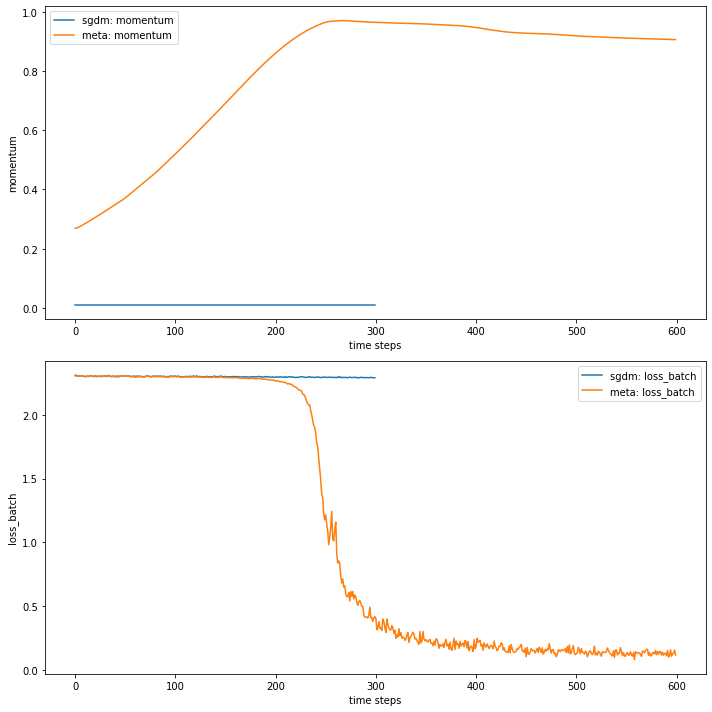

In [147]:
plt.figure(figsize=(10,10))
util.plot_accumulators(data)